# Resultados

Este código executa  a plotagem dos resultados do melhor modelo e a comparação com a análise de Caon (2021)

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import sys


In [ ]:

CAMINHO_ARQUIVO = "results.xlsx"
ANO_INICIAL = 2012
ANO_FINAL = 2025
MAPEAMENTO_COLUNAS = {
    'data': ['data', 'data_julgamento', 'julgamento_data', 'date', 'Data'],
    'classe': ['classe', 'processo_classe_sigla', 'tipo_processo', 'Class', 'Classe'],
    'relator': ['relator', 'relator_processo', 'ministro', 'Relator', 'Ministro'],
}

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif', 'font.size': 10, 'axes.labelsize': 11,
    'axes.titlesize': 13, 'xtick.labelsize': 10, 'ytick.labelsize': 10,
    'legend.fontsize': 9, 'axes.titleweight': 'bold', 'axes.labelweight': 'bold',
    'figure.dpi': 300, 'axes.spines.top': False, 'axes.spines.right': False
})

PALETA_CORES = plt.cm.viridis(np.linspace(0, 1, 6))


def carregar_e_processar_dados(caminho, mapeamento):
    """Carrega dados do Excel, mapeia colunas e processa campos essenciais."""
    try:
        df = pd.read_excel(caminho)
    except FileNotFoundError:
        print(f"ERRO: O arquivo '{caminho}' não foi encontrado. Verifique o caminho.")
        return None
    except Exception as e:
        print(f"ERRO: Falha ao carregar o arquivo '{caminho}'. Detalhe: {e}")
        return None

    df_proc = pd.DataFrame()
    for campo, possibilidades in mapeamento.items():
        coluna_encontrada = next((col for col in possibilidades if col in df.columns), None)
        if coluna_encontrada:
            df_proc[campo] = df[coluna_encontrada]

    if 'data' in df_proc:
        df_proc['data'] = pd.to_datetime(df_proc['data'], errors='coerce')
        df_proc.dropna(subset=['data'], inplace=True)
        df_proc['ano'] = df_proc['data'].dt.year
    
    if df_proc.empty or all(col not in df_proc for col in mapeamento.keys()):
        print("ERRO: Nenhuma coluna válida foi mapeada ou não há dados. Encerrando.")
        return None
        
    print(f"INFO: Dados carregados e processados. {len(df_proc)} registros válidos.")
    return df_proc

def adicionar_rotulos_barras(ax, orientacao='vertical'):
    """Adiciona rótulos de dados às barras de um gráfico."""
    params = {'ha': 'center', 'va': 'bottom', 'fontsize': 8, 'color': 'black'}
    if orientacao == 'vertical':
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.text(p.get_x() + p.get_width() / 2., height, f'{int(height)}', **params)
    else: # horizontal
        params.update({'ha': 'left', 'va': 'center'})
        for p in ax.patches:
            width = p.get_width()
            if width > 0:
                ax.text(width, p.get_y() + p.get_height() / 2., f' {int(width)}', **params)


def plotar_distribuicao_por_ano(df):
    """Gera e salva o gráfico de barras da distribuição de registros por ano."""
    if 'ano' not in df.columns:
        print("WARN: Coluna 'ano' não encontrada. Pulando gráfico de distribuição por ano.")
        return
        
    plt.figure(figsize=(10, 6))
    anos_count = df['ano'].value_counts().reindex(range(ANO_INICIAL, ANO_FINAL + 1), fill_value=0)
    
    ax = anos_count.plot(kind='bar', color='#2E4057', width=0.8)
    ax.set_title('Distribuição de Registros por Ano')
    ax.set_xlabel('Ano')
    ax.set_ylabel('Número de Registros')
    plt.xticks(rotation=45)
    
    adicionar_rotulos_barras(ax, orientacao='vertical')
    plt.tight_layout()
    plt.savefig('figure_1_distribuicao_ano.png')
    plt.show()
    print("SUCCESS: Gráfico 'figure_1_distribuicao_ano.png' salvo.")

def plotar_top_categorias(df):
    """Gera e salva o gráfico de barras das 8 principais categorias."""
    if 'classe' not in df.columns:
        print("WARN: Coluna 'classe' não encontrada. Pulando gráfico de top categorias.")
        return
        
    plt.figure(figsize=(10, 6))
    ax = df['classe'].value_counts().nlargest(8).sort_values().plot(kind='barh', color='#048A81', width=0.8)
    ax.set_title('Top 8 Categorias de Processos')
    ax.set_xlabel('Número de Registros')
    
    adicionar_rotulos_barras(ax, orientacao='horizontal')
    plt.tight_layout()
    plt.savefig('figure_2_top_categorias.png')
    plt.show()
    print("SUCCESS: Gráfico 'figure_2_top_categorias.png' salvo.")

def plotar_top_relatores(df):
    """Gera e salva o gráfico de barras dos 15 principais relatores."""
    if 'relator' not in df.columns:
        print("WARN: Coluna 'relator' não encontrada. Pulando gráfico de top relatores.")
        return
        
    plt.figure(figsize=(10, 7))
    ax = df['relator'].value_counts().nlargest(15).sort_values().plot(kind='barh', color='#2E4057', width=0.8)
    ax.set_title('Top 15 Relatores por Volume de Registros')
    ax.set_xlabel('Número de Registros')
    
    adicionar_rotulos_barras(ax, orientacao='horizontal')
    plt.tight_layout()
    plt.savefig('figure_3_top_relatores.png')
    plt.show()
    print("SUCCESS: Gráfico 'figure_3_top_relatores.png' salvo.")

def plotar_atividade_anual_relatores(df):
    """Gera e salva o gráfico de barras empilhadas da atividade anual dos 6 principais relatores."""
    if not all(c in df.columns for c in ['ano', 'relator']):
        print("WARN: Colunas 'ano' ou 'relator' não encontradas. Pulando gráfico de atividade de relatores.")
        return
        
    plt.figure(figsize=(12, 7))
    top_6_relatores = df['relator'].value_counts().nlargest(6).index
    crosstab_relator = pd.crosstab(df['ano'], df['relator'])[top_6_relatores]
    
    ax = crosstab_relator.reindex(range(ANO_INICIAL, ANO_FINAL + 1), fill_value=0).plot(
        kind='bar', stacked=True, color=PALETA_CORES, width=0.85, figsize=(12, 7)
    )
    ax.set_title('Atividade Anual dos Top 6 Relatores')
    ax.set_xlabel('Ano')
    ax.set_ylabel('Número de Registros')
    plt.xticks(rotation=45)
    ax.legend(title='Relator', frameon=False, loc='upper left')
    
    plt.tight_layout()
    plt.savefig('figure_4_atividade_relatores.png')
    plt.show()
    print("SUCCESS: Gráfico 'figure_4_atividade_relatores.png' salvo.")

def plotar_distribuicao_percentual_categorias(df):
    """Gera e salva o gráfico de barras empilhadas com a distribuição percentual das 6 principais categorias."""
    if not all(c in df.columns for c in ['ano', 'classe']):
        print("WARN: Colunas 'ano' ou 'classe' não encontradas. Pulando gráfico de distribuição percentual.")
        return

    top_6_categorias = df['classe'].value_counts().nlargest(6).index
    crosstab_abs = pd.crosstab(df['ano'], df['classe'])[top_6_categorias]
    crosstab_top = crosstab_abs.reindex(range(ANO_INICIAL, ANO_FINAL + 1), fill_value=0)
    crosstab_perc = crosstab_top.div(crosstab_top.sum(axis=1), axis=0).fillna(0) * 100

    ax = crosstab_perc.plot(kind='bar', stacked=True, color=PALETA_CORES, width=0.9, figsize=(12, 7))
    ax.set_title('Distribuição Percentual das Top 6 Categorias por Ano')
    ax.set_ylabel('Percentual (%)')
    ax.set_xlabel('Ano')
    ax.legend(title='Categoria', frameon=False, bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta para a legenda externa
    plt.savefig('figure_5_distribuicao_percentual_categorias.png')
    plt.show()
    print("SUCCESS: Gráfico 'figure_5_distribuicao_percentual_categorias.png' salvo.")

def plotar_heatmap_categorias(df):
    """Gera e salva um heatmap com as ocorrências absolutas das 6 principais categorias por ano."""
    if not all(c in df.columns for c in ['ano', 'classe']):
        print("WARN: Colunas 'ano' ou 'classe' não encontradas. Pulando heatmap.")
        return
        
    plt.figure(figsize=(12, 7))
    top_6_categorias = df['classe'].value_counts().nlargest(6).index
    crosstab_abs = pd.crosstab(df['ano'], df['classe'])[top_6_categorias]
    heatmap_data = crosstab_abs.reindex(range(ANO_INICIAL, ANO_FINAL + 1), fill_value=0).T
    
    ax = sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='d', linewidths=.5)
    ax.set_title('Ocorrências Absolutas das Top 6 Categorias por Ano (Heatmap)')
    ax.set_xlabel('Ano')
    ax.set_ylabel('Categoria')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig('figure_6_heatmap_categorias.png')
    plt.show()
    print("SUCCESS: Gráfico 'figure_6_heatmap_categorias.png' salvo.")

def carregar_dados_caon(caminho):
    """Carrega e processa os dados do arquivo Caon para contagem anual."""
    try:
        df = pd.read_excel(caminho)
    except FileNotFoundError:
        print(f"ERRO: O arquivo '{caminho}' não foi encontrado.")
        return None
    except Exception as e:
        print(f"ERRO: Falha ao carregar '{caminho}'. Detalhe: {e}")
        return None

    if 'ANO' not in df.columns or 'NÚMERO DO PROCESSO' not in df.columns:
        print("ERRO: Caon.xlsx precisa das colunas 'ANO' e 'NÚMERO DO PROCESSO'.")
        return None
    df['ano_numerico'] = pd.to_datetime(df['ANO'], errors='coerce').dt.year
    df.dropna(subset=['ano_numerico'], inplace=True)
    df['ano_numerico'] = df['ano_numerico'].astype(int)

    print(f"INFO: Dados de '{caminho}' carregados e processados. {len(df)} registros válidos.")
    return df['ano_numerico'].value_counts()

def plotar_comparativo_anual(contagem_scraptf, contagem_caon):
    """Gera e salva o gráfico de barras comparativo entre os dois datasets."""
    if contagem_caon is None:
        print("WARN: Dados do Caon não foram carregados. Pulando gráfico comparativo.")
        return

    df_comp = pd.DataFrame({
        'SVC': contagem_scraptf,
        'Caon': contagem_caon
    }).reindex(range(ANO_INICIAL, ANO_FINAL + 1)).fillna(0)

    plt.figure(figsize=(12, 7))
    ax = df_comp.plot(kind='bar', color=['#2E4057', '#048A81'], width=0.8, figsize=(12, 7))
    
    ax.set_title('Comparativo Anual de Processos: SVC vs. Caon')
    ax.set_xlabel('Ano')
    ax.set_ylabel('Número de Processos')
    plt.xticks(rotation=45)
    ax.legend(title='Fonte de Dados', frameon=False)

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2., height, f'{int(height)}', 
                    ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig('figure_comparativo_anual.png')
    plt.show()
    print("SUCCESS: Gráfico 'figure_comparativo_anual.png' salvo.")

def main():
    """Função principal que orquestra toda a análise."""
    print("INFO: Iniciando script de análise de dados.")
    df_scraptf = carregar_dados_scraptf(CAMINHO_ARQUIVO_SCRAPTF, MAPEAMENTO_COLUNAS)
    
    if df_scraptf is None:
        sys.exit()

    contagem_caon = carregar_dados_caon(CAMINHO_ARQUIVO_CAON)

    print("\nINFO: Iniciando a geração dos gráficos...")
    
    contagem_scraptf_anual = df_scraptf['ano'].value_counts()
    plotar_comparativo_anual(contagem_scraptf_anual, contagem_caon)
    
    print("\nINFO: Análise concluída.")

INFO: Iniciando script de análise de dados.
INFO: Dados carregados e processados. 266 registros válidos.
INFO: Dados de 'Caon.xlsx' carregados e processados. 26 registros válidos.

INFO: Iniciando a geração dos gráficos individuais...


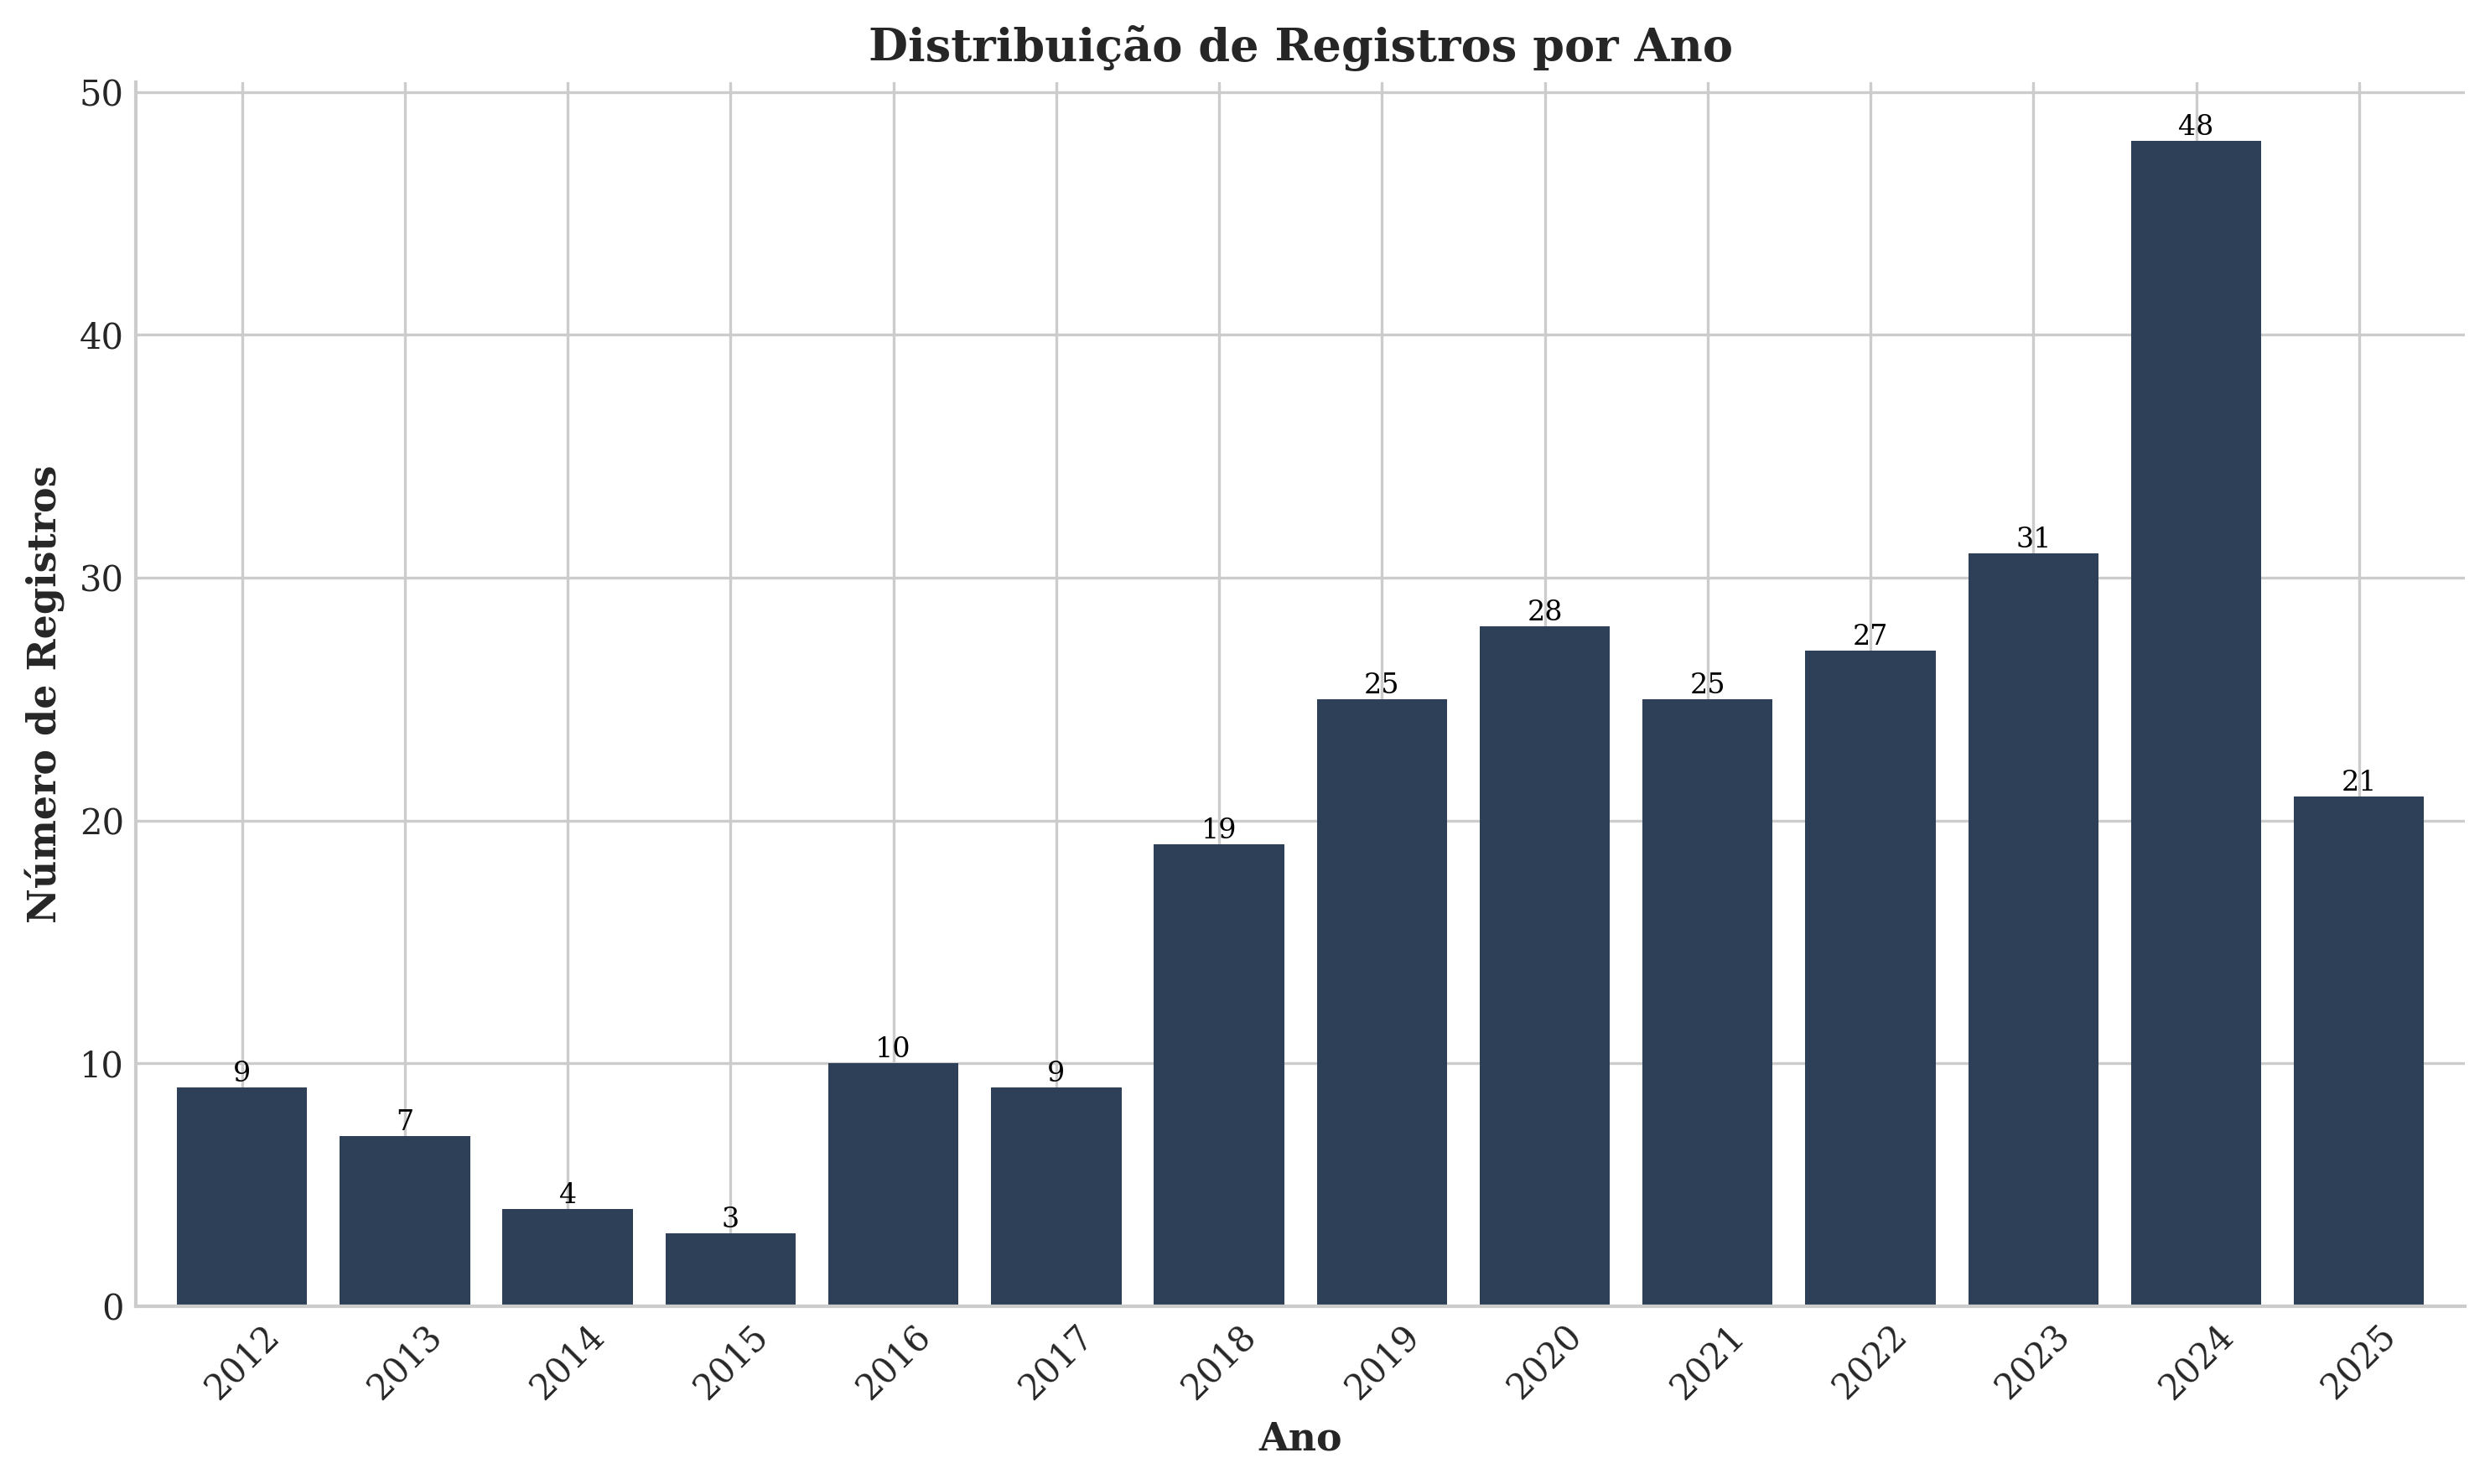

SUCCESS: Gráfico 'figure_1_distribuicao_ano.png' salvo.


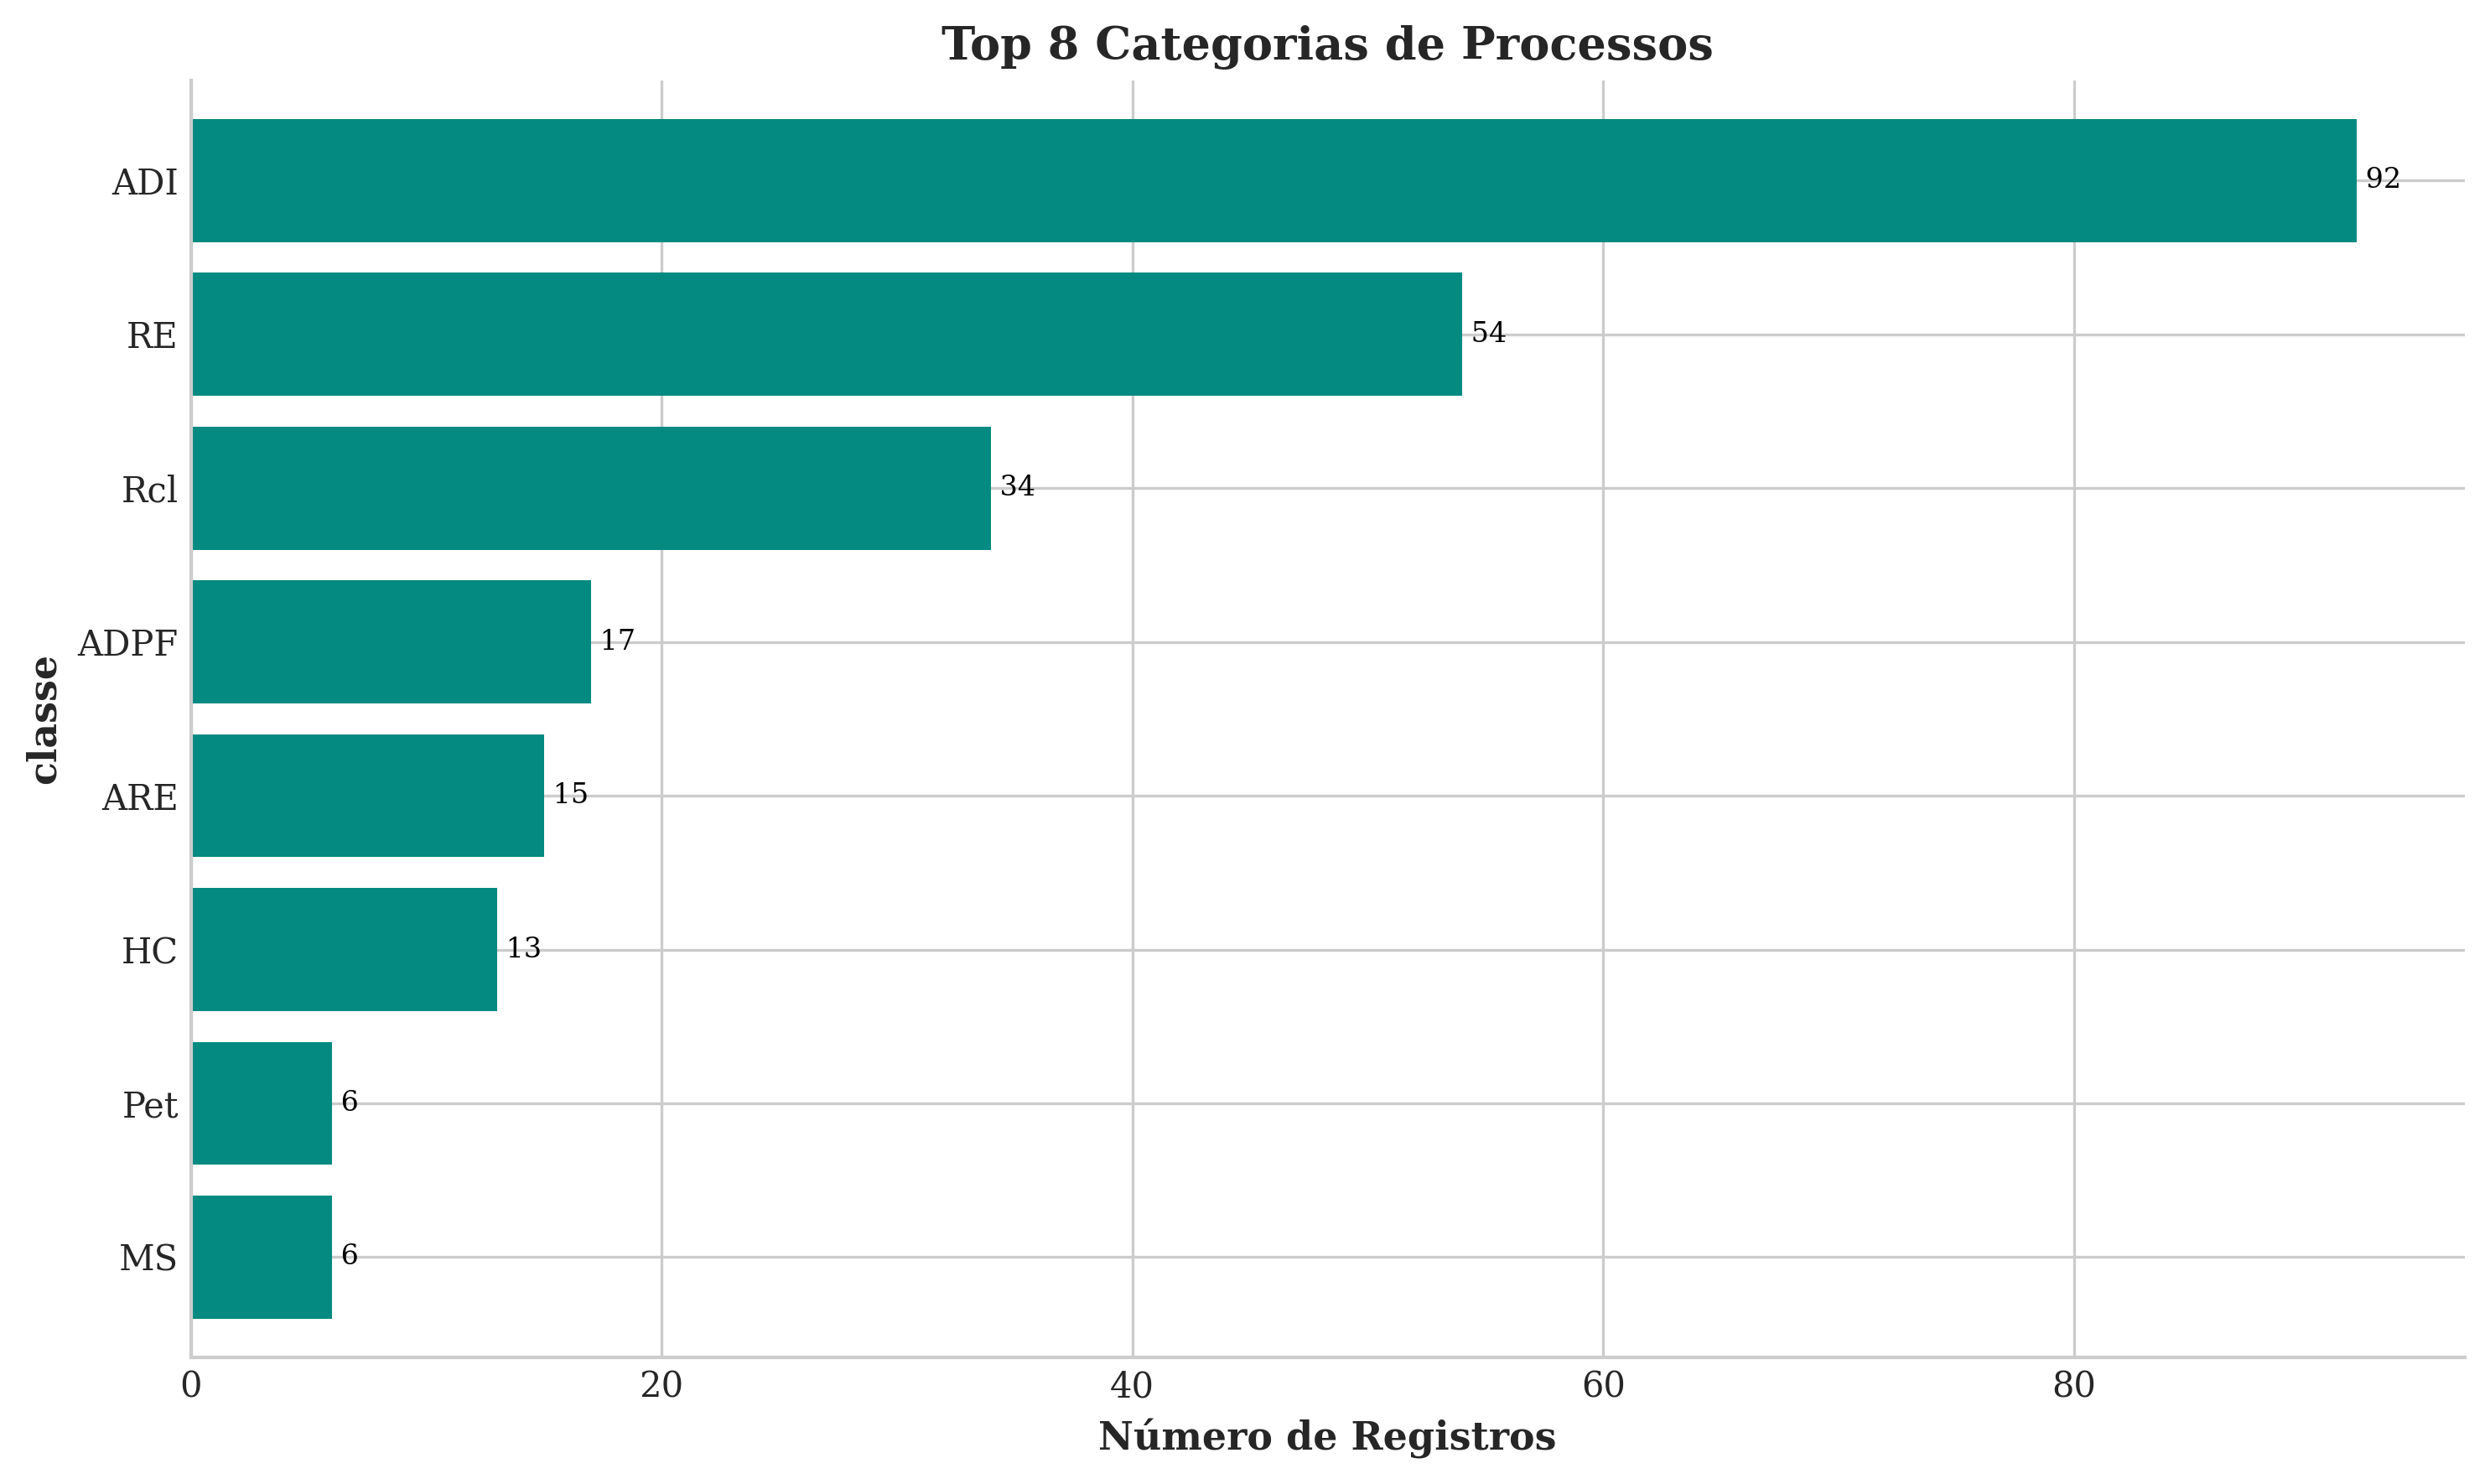

SUCCESS: Gráfico 'figure_2_top_categorias.png' salvo.


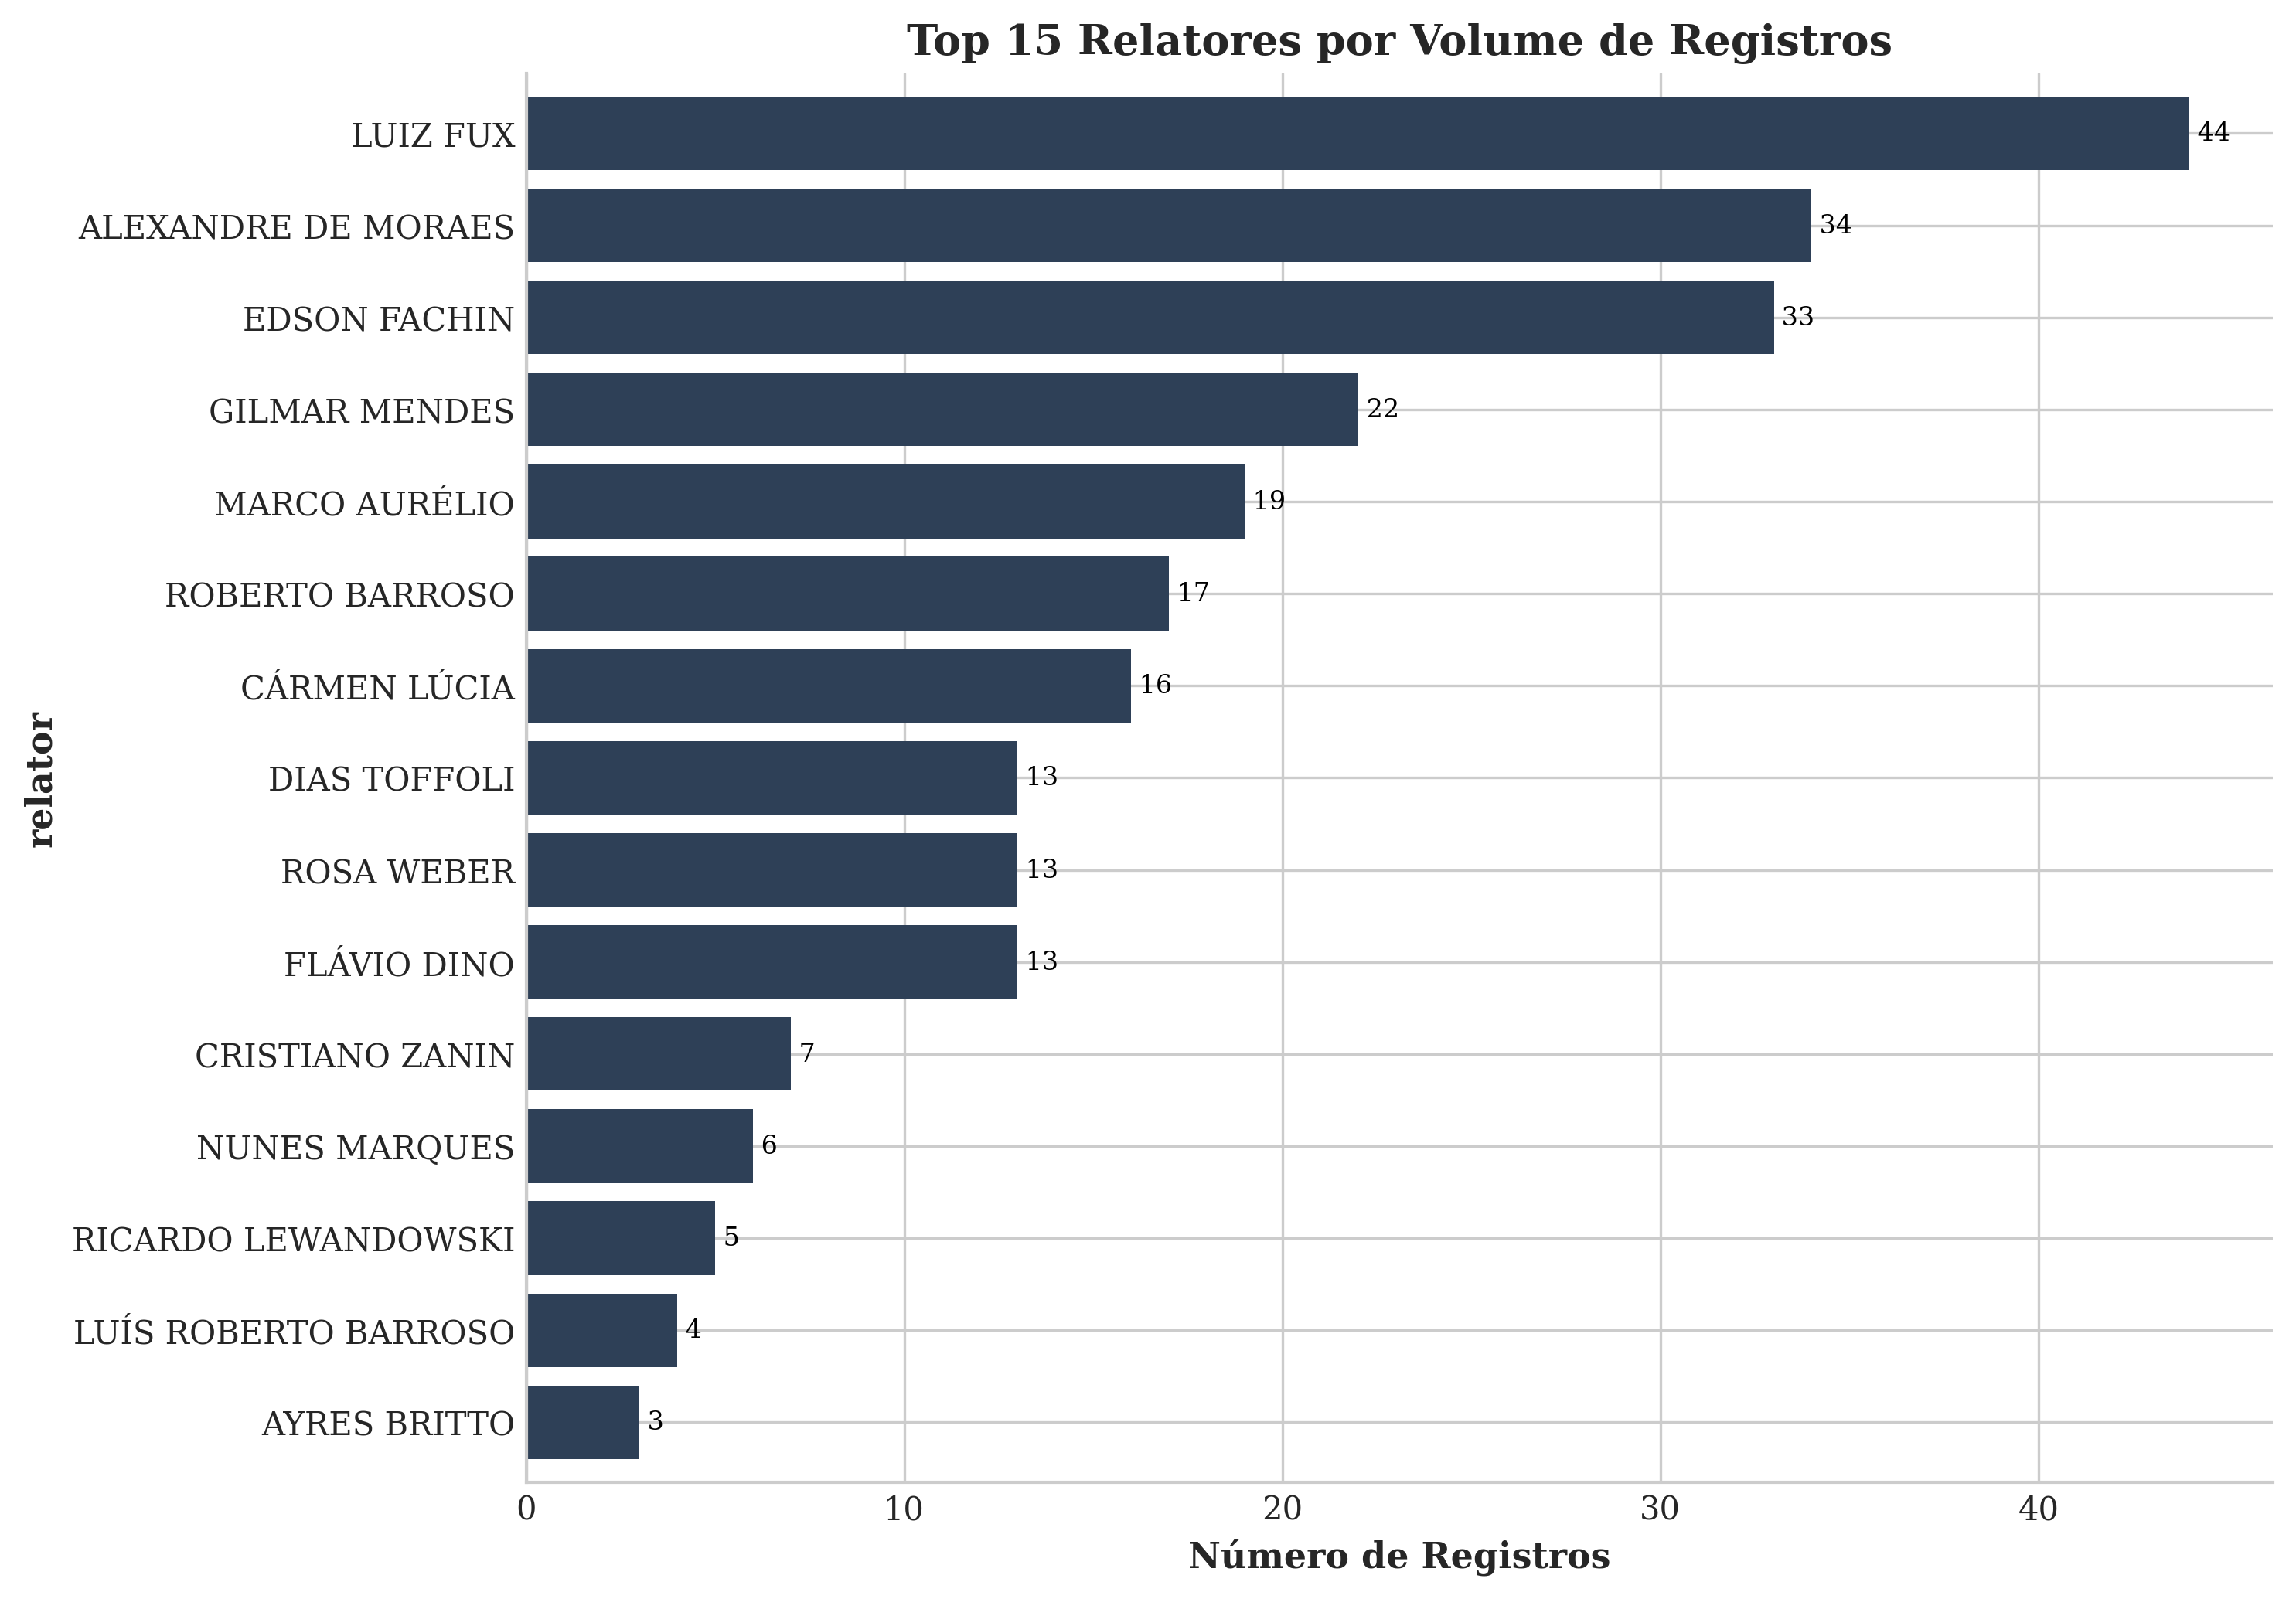

SUCCESS: Gráfico 'figure_3_top_relatores.png' salvo.


<Figure size 3600x2100 with 0 Axes>

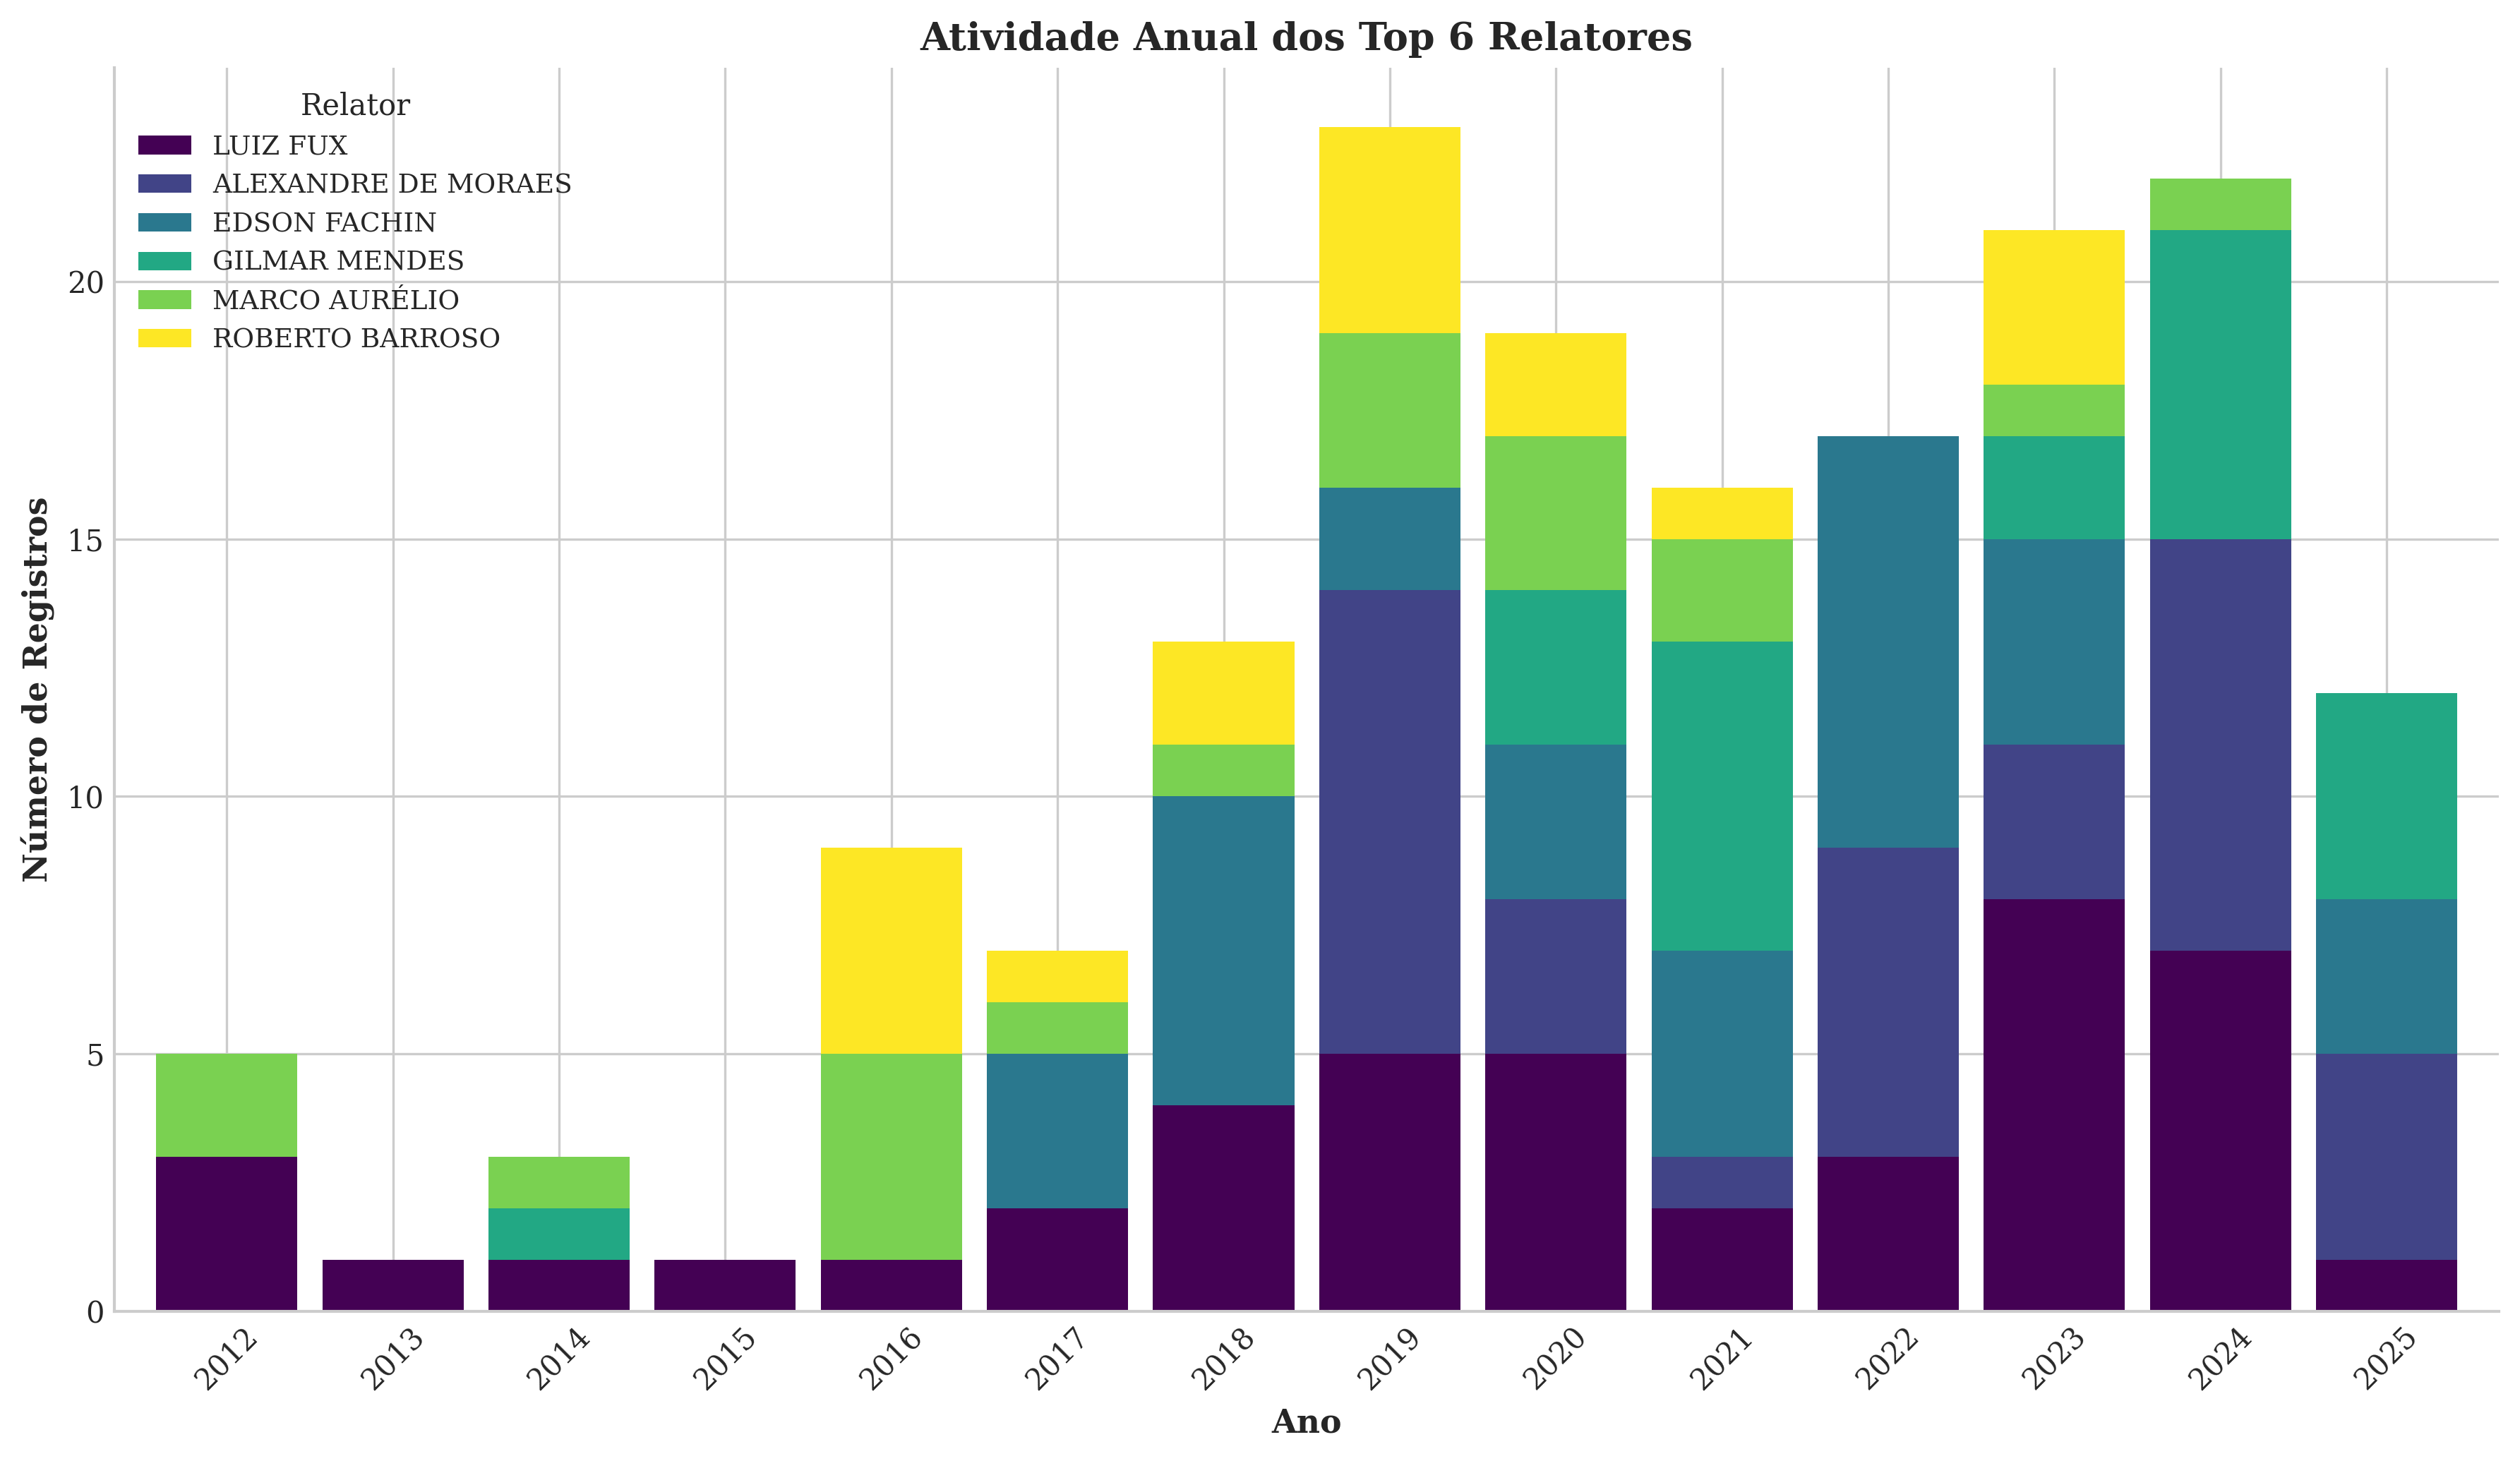

SUCCESS: Gráfico 'figure_4_atividade_relatores.png' salvo.


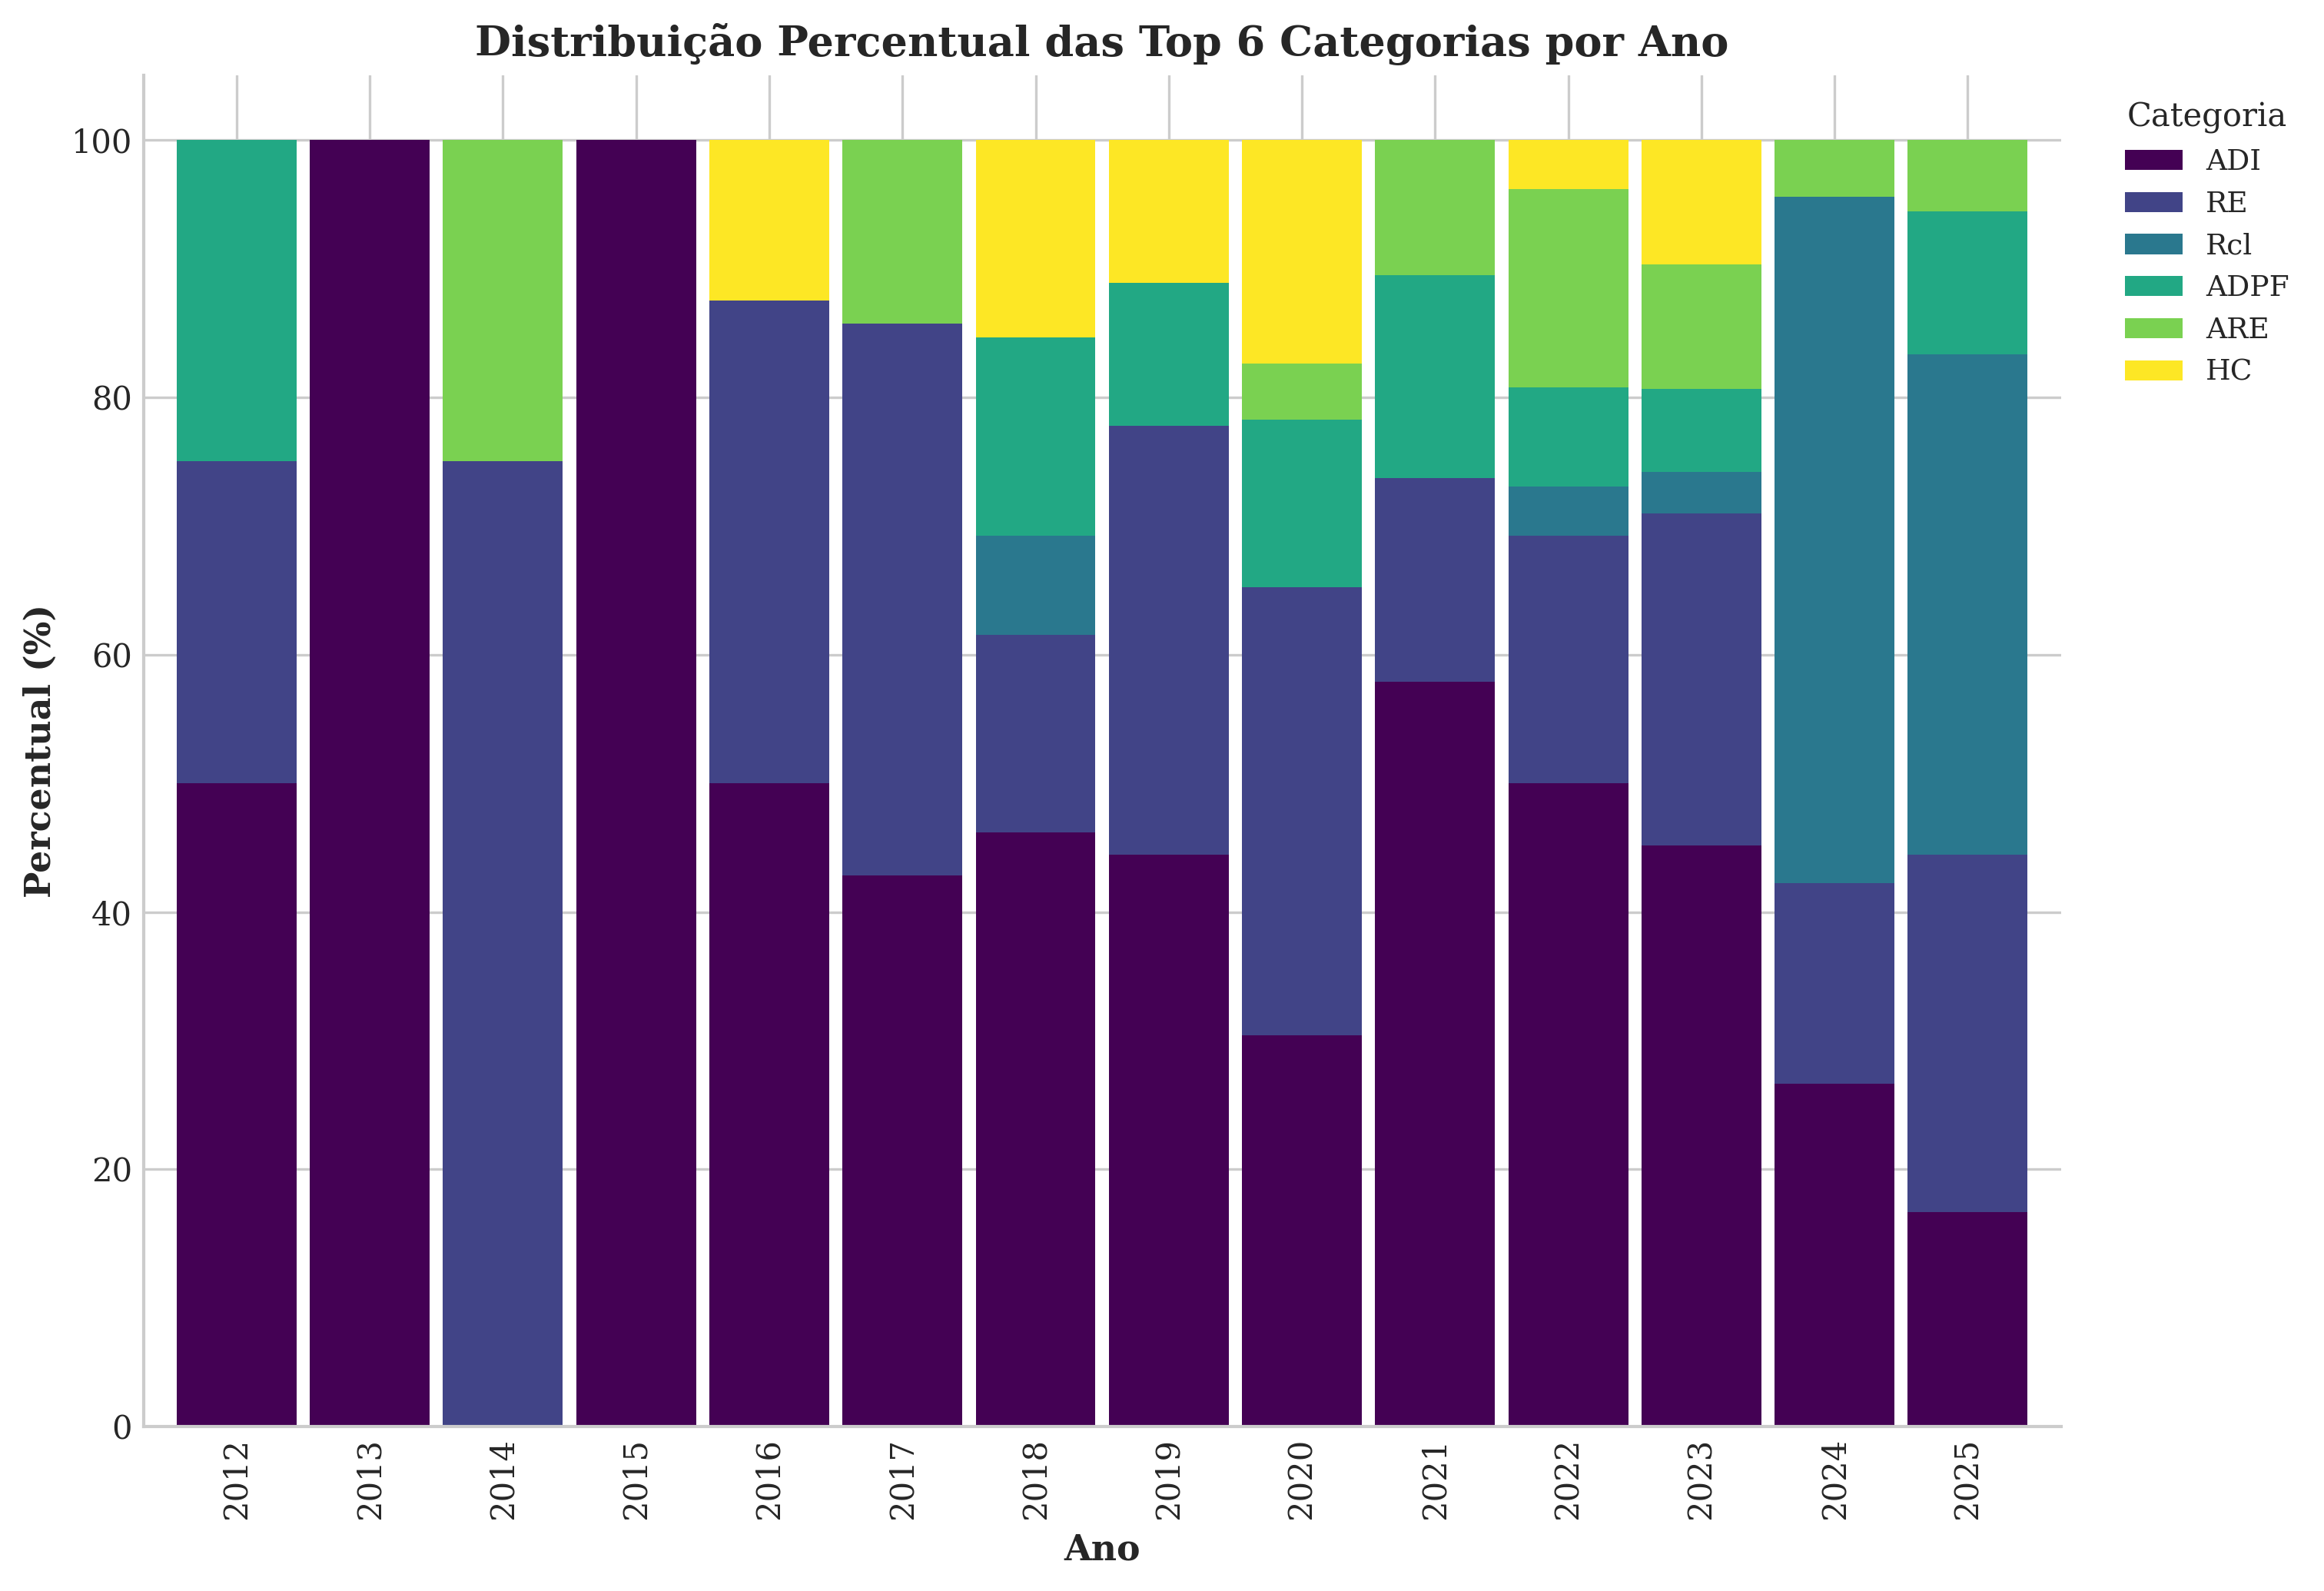

SUCCESS: Gráfico 'figure_5_distribuicao_percentual_categorias.png' salvo.


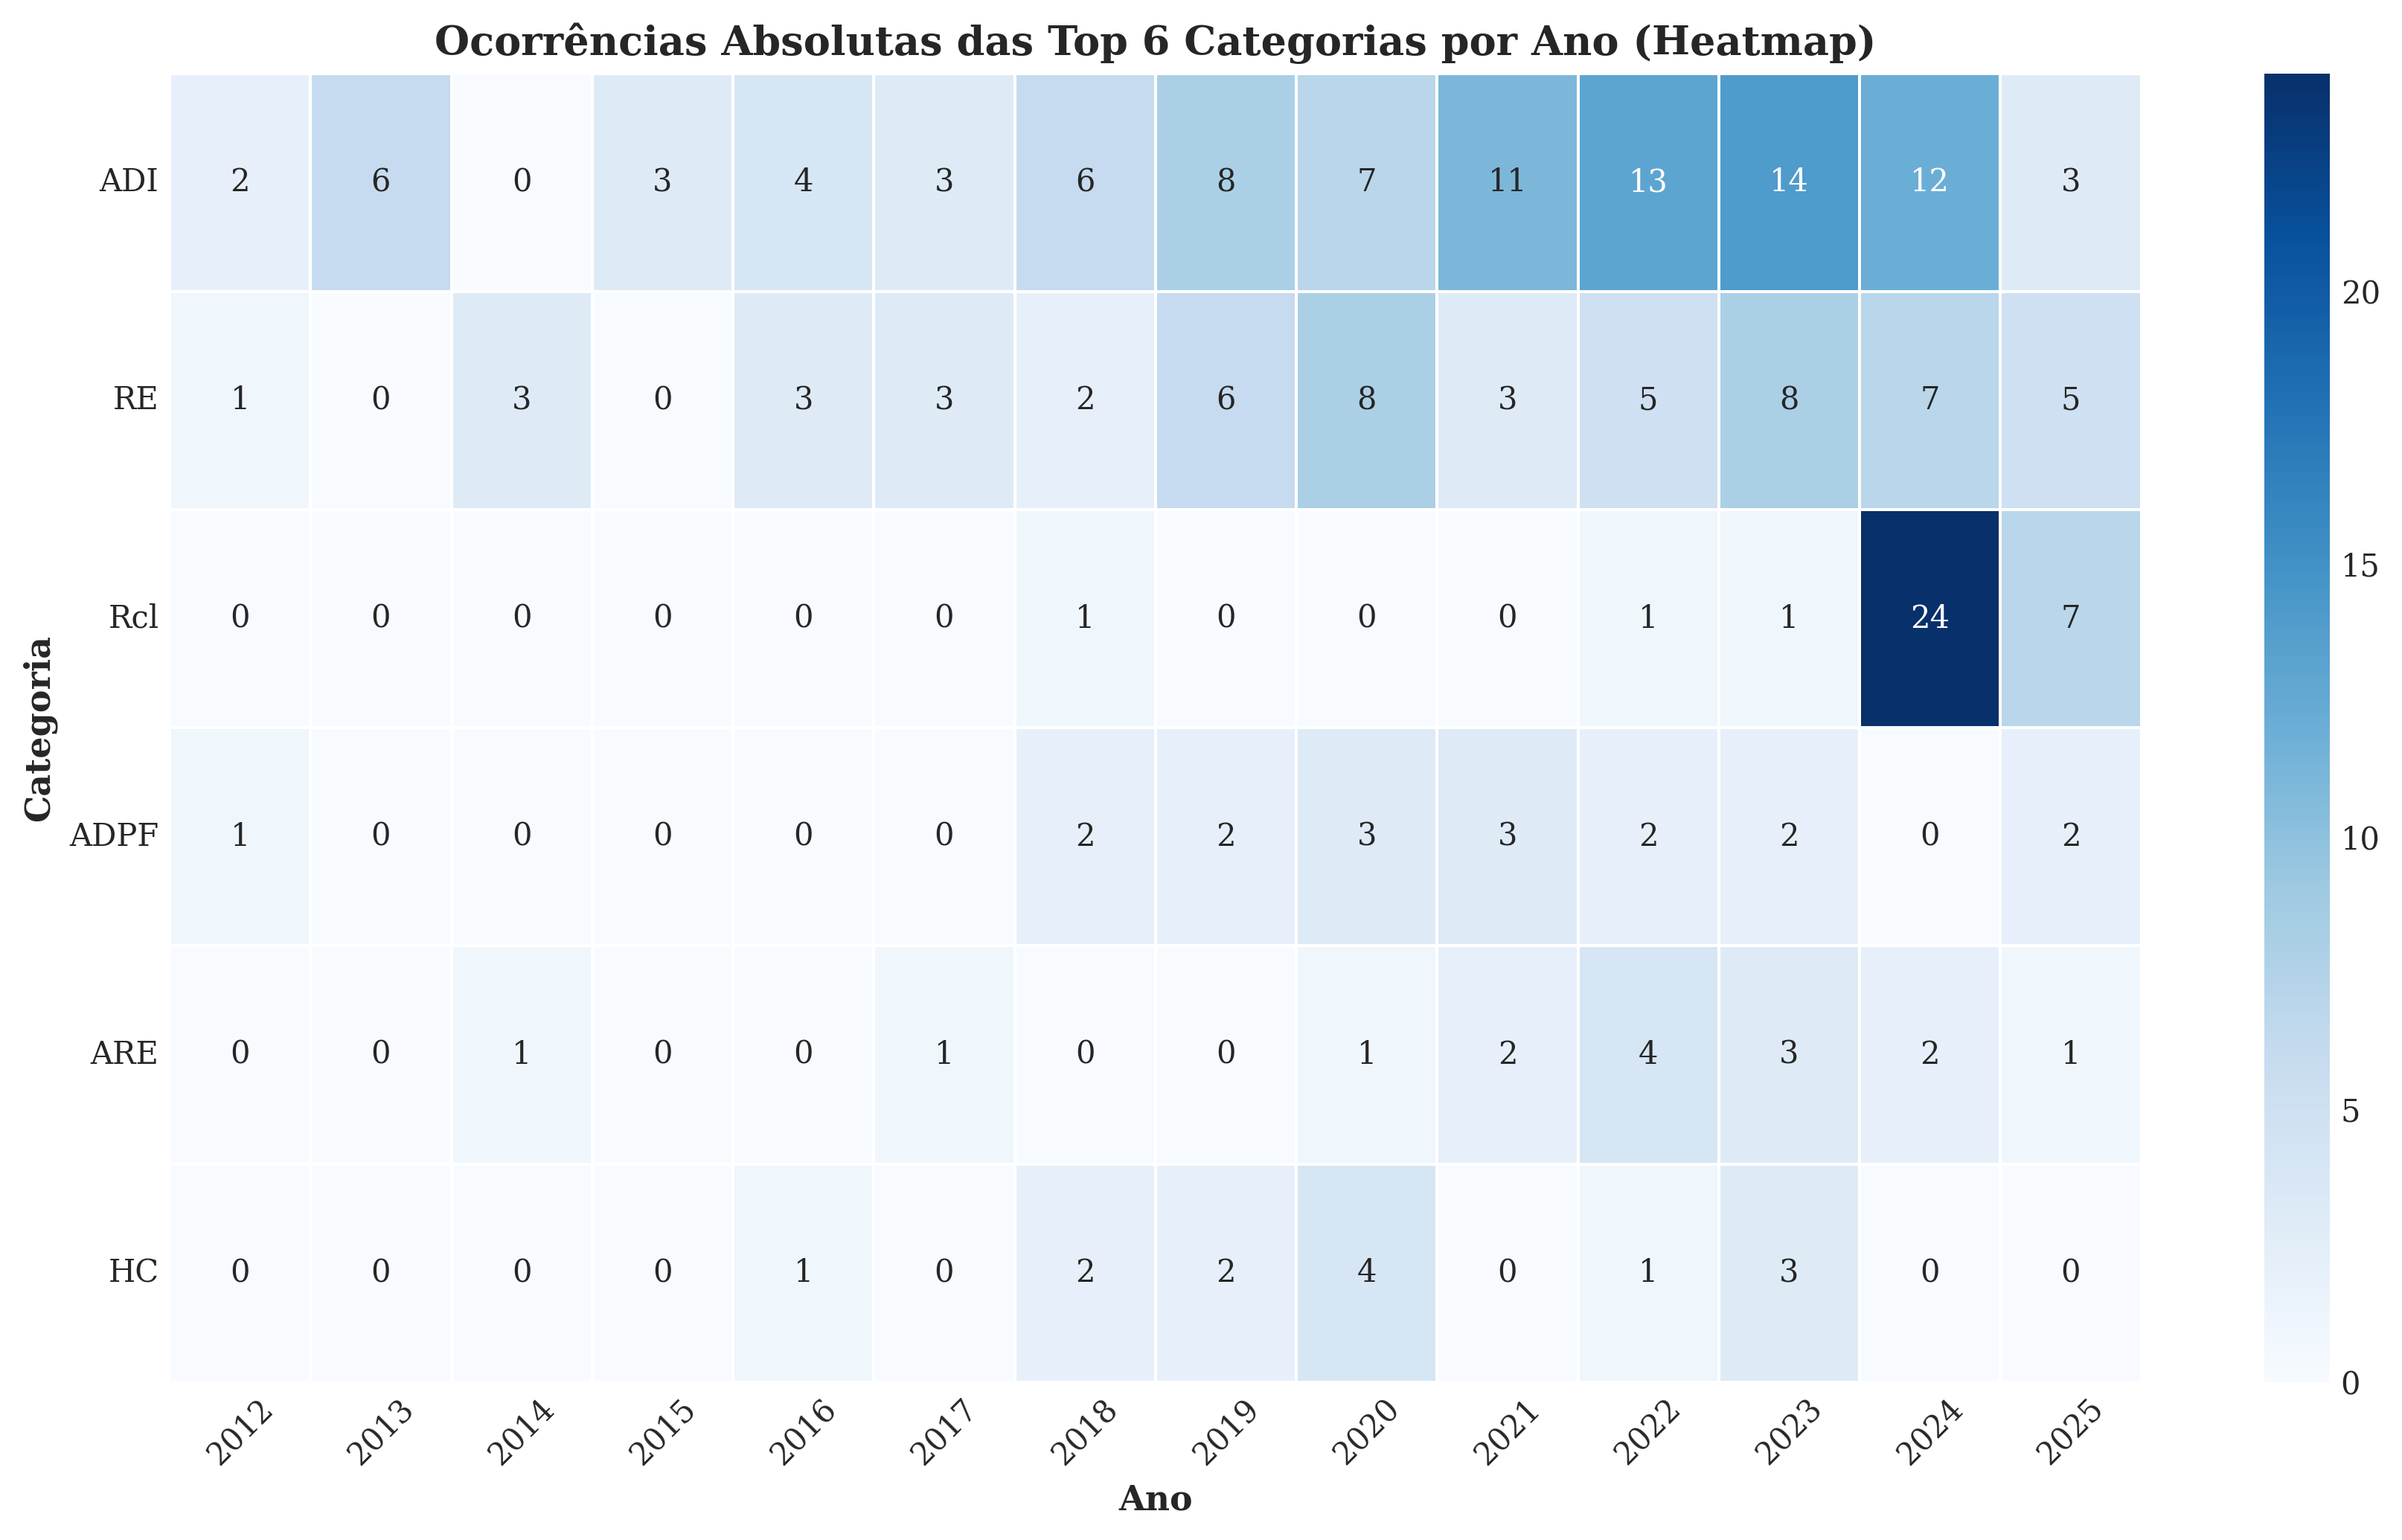

SUCCESS: Gráfico 'figure_6_heatmap_categorias.png' salvo.


<Figure size 3600x2100 with 0 Axes>

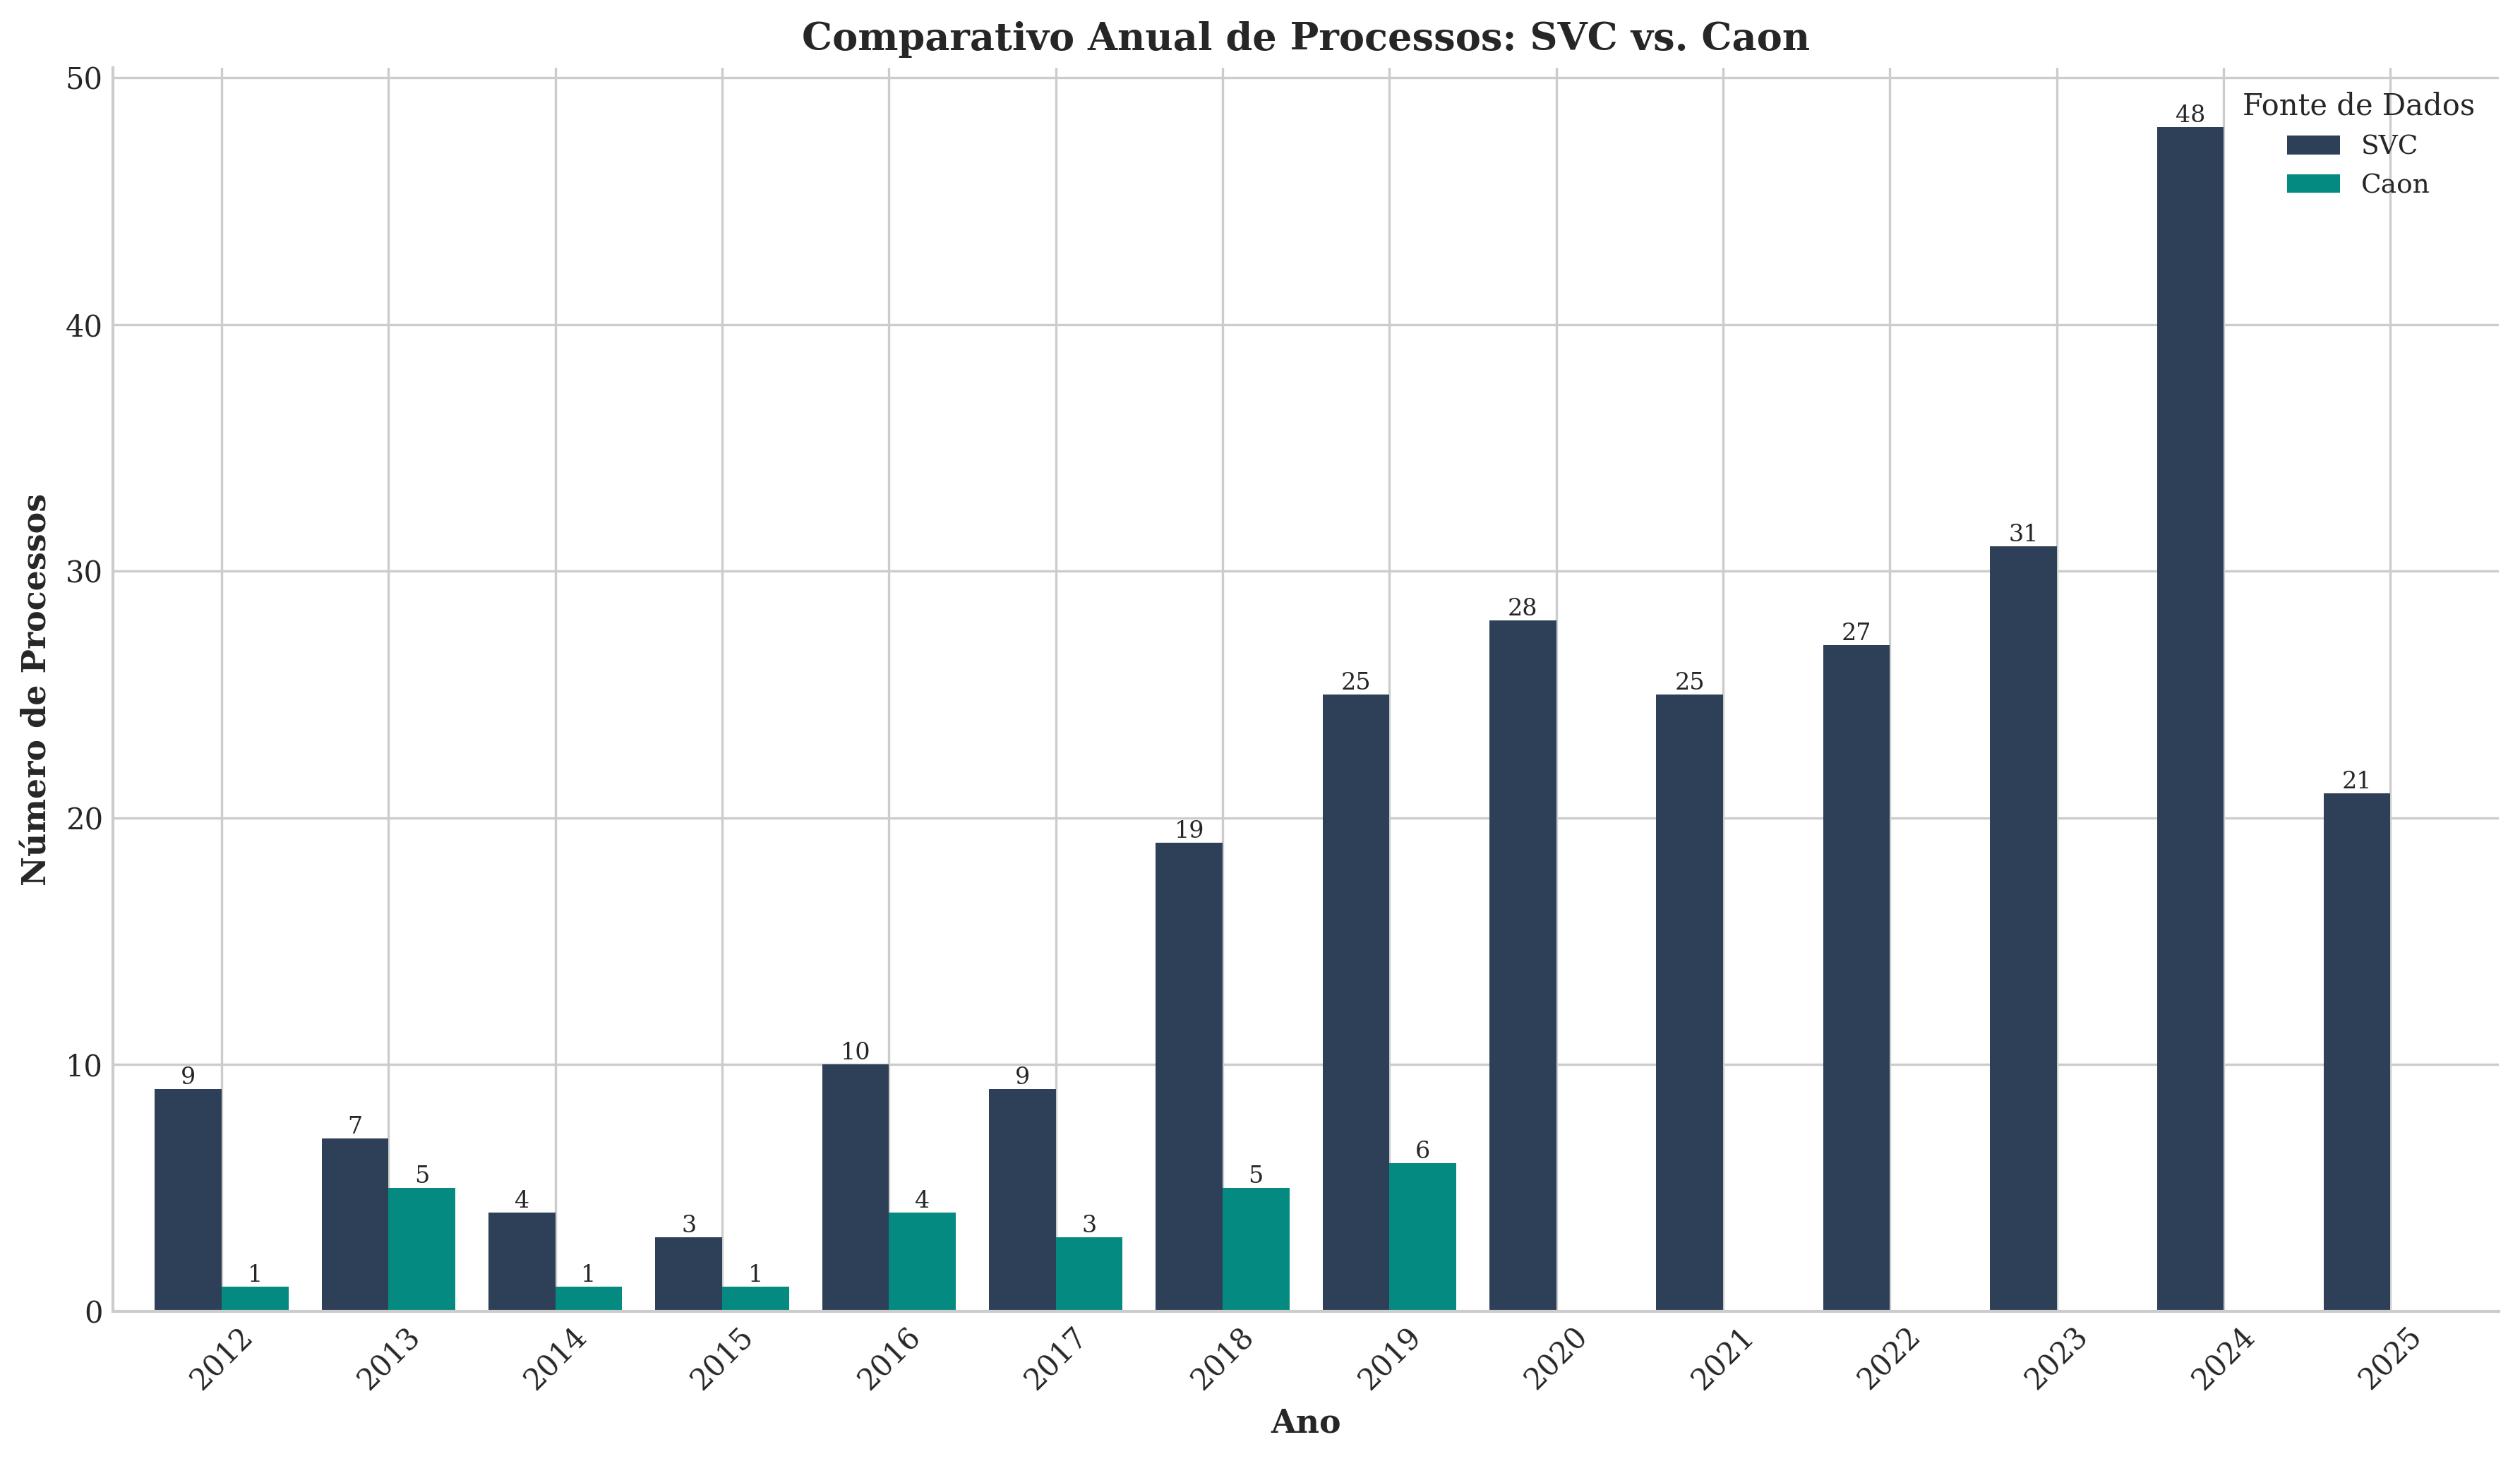

SUCCESS: Gráfico 'figure_comparativo_anual.png' salvo.

INFO: Análise concluída.


In [ ]:
def main():
    """Função principal que orquestra o carregamento dos dados e a geração dos gráficos."""
    print("INFO: Iniciando script de análise de dados.")
    df = carregar_e_processar_dados(CAMINHO_ARQUIVO, MAPEAMENTO_COLUNAS)
    
    if df is None:
        sys.exit()

    CAMINHO_ARQUIVO_CAON = "Caon.xlsx" 
    contagem_caon = carregar_dados_caon(CAMINHO_ARQUIVO_CAON)

    print("\nINFO: Iniciando a geração dos gráficos individuais...")
    plotar_distribuicao_por_ano(df)
    plotar_top_categorias(df)
    plotar_top_relatores(df)
    plotar_atividade_anual_relatores(df)
    plotar_distribuicao_percentual_categorias(df)
    plotar_heatmap_categorias(df)
    contagem_original = df['ano'].value_counts()
    plotar_comparativo_anual(contagem_original, contagem_caon)
    
    print("\nINFO: Análise concluída.")

if __name__ == "__main__":
    main()